In [1]:
import denoising
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from skimage.transform import rescale

In [2]:
def mode(ndarray, axis=0):
    # Check inputs
    ndarray = np.asarray(ndarray)
    ndim = ndarray.ndim
    if ndarray.size == 1:
        return (ndarray[0], 1)
    elif ndarray.size == 0:
        raise Exception('Cannot compute mode on empty array')
    try:
        axis = range(ndarray.ndim)[axis]
    except:
        raise Exception('Axis "{}" incompatible with the {}-dimension array'.format(axis, ndim))

    # If array is 1-D and numpy version is > 1.9 numpy.unique will suffice
    if all([ndim == 1,
            int(np.__version__.split('.')[0]) >= 1,
            int(np.__version__.split('.')[1]) >= 9]):
        modals, counts = np.unique(ndarray, return_counts=True)
        index = np.argmax(counts)
        return modals[index], counts[index]

    # Sort array
    sort = np.sort(ndarray, axis=axis)
    # Create array to transpose along the axis and get padding shape
    transpose = np.roll(np.arange(ndim)[::-1], axis)
    shape = list(sort.shape)
    shape[axis] = 1
    # Create a boolean array along strides of unique values
    strides = np.concatenate([np.zeros(shape=shape, dtype='bool'),
                                 np.diff(sort, axis=axis) == 0,
                                 np.zeros(shape=shape, dtype='bool')],
                                axis=axis).transpose(transpose).ravel()
    # Count the stride lengths
    counts = np.cumsum(strides)
    counts[~strides] = np.concatenate([[0], np.diff(counts[~strides])])
    counts[strides] = 0
    # Get shape of padded counts and slice to return to the original shape
    shape = np.array(sort.shape)
    shape[axis] += 1
    shape = shape[transpose]
    slices = [slice(None)] * ndim
    slices[axis] = slice(1, None)
    # Reshape and compute final counts
    counts = counts.reshape(shape).transpose(transpose)[slices] + 1

    # Find maximum counts and return modals/counts
    slices = [slice(None, i) for i in sort.shape]
    del slices[axis]
    index = np.ogrid[slices]
    index.insert(axis, np.argmax(counts, axis=axis))
    return sort[index]

/home/redzin/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


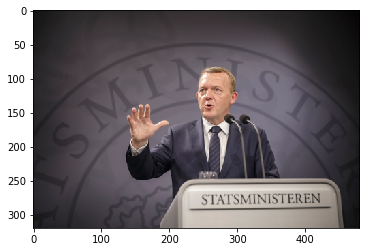

In [3]:
# Load the image
img = rescale(plt.imread('data/lars.jpg'),0.5)
img = skimage.img_as_float(img)
plt.imshow(img, cmap='gray')

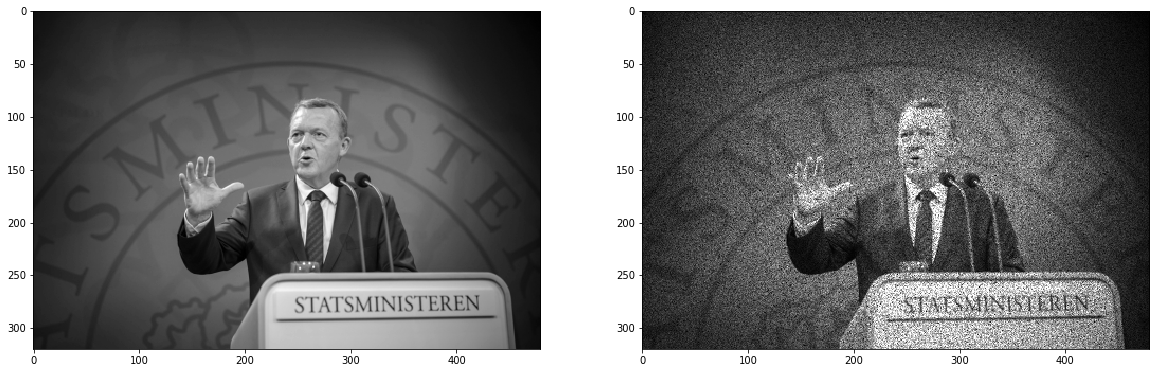

In [4]:
# Image pre-processing (degradation, etc.)
X = np.mean(img, 2)
Y = skimage.util.random_noise(X, 'speckle', mean=0, var=0.07)

plt.imsave("results/lars-X", X, format='png', cmap='gray')
plt.imsave("results/lars-Y", Y, format='png', cmap='gray')


fig, axarr = plt.subplots(1,2, figsize=(20,20))

axarr[0].imshow(X, cmap='gray')
axarr[1].imshow(Y, cmap='gray')


In [5]:
pottsobj = denoising.PottsMH(Y, beta=100, sigma=Y.std(), bins = 12)

In [6]:
%time X_samples = [pottsobj.solve(10) for i in range(20)]

CPU times: user 8.82 s, sys: 32 ms, total: 8.85 s
Wall time: 8.83 s


In [7]:
X_mean = np.mean(X_samples, 0)
X_mode = mode(X_samples, 0)

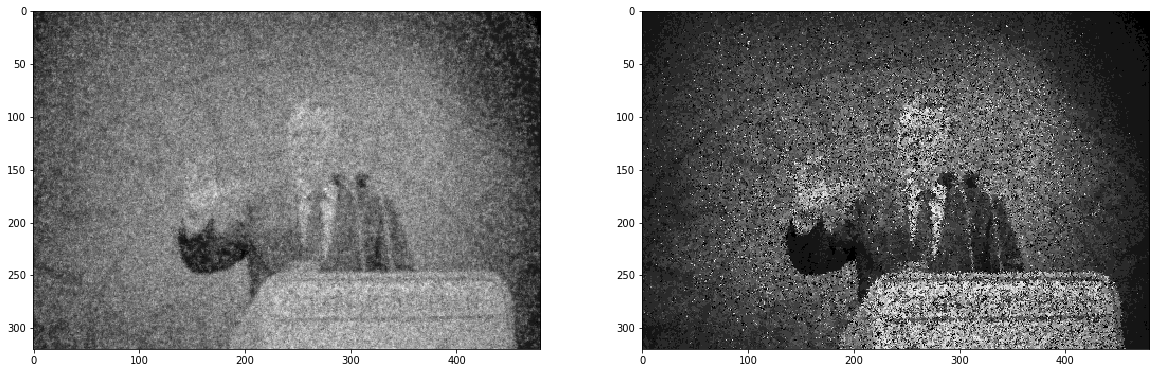

In [8]:
fig, axarr = plt.subplots(1,2, figsize=(20,20))


axarr[0].imshow(X_mean, cmap='gray')
axarr[1].imshow(X_mode, cmap='gray')


plt.imsave("results/lars-10-colours-mean-reconstructed", X_mean, format='png', cmap='gray')
plt.imsave("results/lars-10-colours-mode-reconstructed", X_mode, format='png', cmap='gray')
